In [1]:
import io 
import numpy as np

import torch
from matplotlib import pyplot as plt
from IPython.display import Audio

## define a pytorch model with a function (`sample`) we would like to export

In [391]:
# # class Basic(torch.nn.Module):
# #     def forward(self, x, y):
# #         return x+y

# class Basic(torch.nn.Module):
#     def __init__(self, emb_size, hidden_size):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.cell = torch.nn.GRUCell(emb_size, hidden_size)
#         self.proj = torch.nn.Linear(hidden_size, 1)
#         self.emb = torch.nn.Linear(1, emb_size)
#     def forward(self, h, x):
#         # x: sample [batch x channels]
#         # h: hidden state [batch x hidden]
#         # returns: next hidden state, next sample
#         h = self.cell(self.emb(x), h)
#         x = self.proj(h)
#         return h, x    
    
# basic = Basic(64, 128)

In [529]:
# torch has the logit function but ONNX does not
def logit(x):
    return (x/(1-x)).log()

class TorchLogisticCDF(torch.nn.Module):
    def likelihood(self, loc, log_scale, target, resolution=65536):
        # likelihood
        # probably not numerically stable
        d = torch.tensor([0.5, -0.5])/resolution
        inv_scale = (-log_scale).exp()
        prob = (((target - loc)[...,None] + d) * inv_scale[...,None]).sigmoid().sum(-1)
        return prob.clamp(1e-5, 1e5).log()
        
    def sample(self, loc, log_scale, u=None, temp=1):
        scale = log_scale.exp()
        if u is None:
            u = torch.rand(tuple(loc.shape))#torch.rand_like(loc)
        return loc + temp * scale * logit(u)#.logit()
    
# class TorchMixtureLogisticCDF(torch.nn.Module):
#     def __init__(self, n):
#         self.n = n
#         self.input_size = 3*n
        
#     def likelihood(self, h, target, resolution=65536):
#         # likelihood
#         loc, log_scale, log_pi = h.chunk(3, -1)
        
#         d = torch.tensor([0.5, -0.5])/resolution
#         inv_scale = (-log_scale).exp()
#         prob = (((target - loc)[...,None] + d) * scale[...,None]).sigmoid().sum(-1)
#         return prob.log()
        
#     def sample(self, loc, log_scale, u=None, temp=1):
#         scale = log_scale.exp()
#         if u is None:
#             u = torch.rand_like(loc)
#         return loc + temp * scale * logit(u)#.logit()

class TorchRNN(torch.nn.Module):
    """mixture density network with GRU cell"""
    def __init__(self, emb_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.rnn = torch.nn.GRU(emb_size, hidden_size)
        self.rnn_cell = torch.nn.GRUCell(emb_size, hidden_size)
        self.rnn_cell.weight_ih = self.rnn.weight_ih_l0
        self.rnn_cell.weight_hh = self.rnn.weight_hh_l0
        
        self.h0 = torch.nn.Parameter(torch.randn(1,hidden_size))
        
        self.proj = torch.nn.Linear(hidden_size, 2)
        self.emb = torch.nn.Linear(1, emb_size)
        self.output = TorchLogisticCDF()
        
    def sample(self, h, x, u=None, temp=1):
        """
        Args:
            x: sample Tensor[batch x 1]
            h: hidden state Tensor[batch x hidden]
        rReturns: 
            next hidden state Tensor[batch x hidden]
            next sample Tensor[batch x 1]
        """
        h = self.rnn_cell(self.emb(x), h)
        dist_params = self.proj(h)
        # chunk appears to trigger a bug in TVM
        #loc, log_scale = dist_params.chunk(2,-1)
        loc, log_scale = dist_params[...,:1], dist_params[...,1:]
        x = self.output.sample(loc, log_scale, u, temp)
        return h, x
    
    def sample_n(self, h, x_block, n=1, temp=1):
        """
        Args:
            x: sample block [batch x time x 1]
            h: hidden state [batch x hidden]
        Returns: 
            final hidden state Tensor[batch x hidden]
            next sample block Tensor[batch x time x 1]
        """
        xs = []
        x = x_block[:,-1,:]
        for i in range(n):
            h, x = self.sample(h, x, temp=temp)
            xs.append(x)
        return h, torch.stack(xs, -2)
    
    def forward(self, x):
        """
        Args:
            x: signal Tensor[batch x time x 1]
        Returns:
            log likelihood Tensor[batch x time]
        """
        x_emb = self.emb(x)
        h, _ = self.rnn(x_emb, self.h0[None].expand(*x.shape[:2],-1))
        dist_params = self.proj(h[:,:-1])
        loc, log_scale = dist_params.chunk(2,-1)
        return self.output.likelihood(loc, log_scale, x[:,1:])

In [530]:
class ExportWrapper(torch.nn.Module):
    """convenience for exporting model function other than `forward`"""
    # def __init__(self, cls, fn_name, *a, **kw):
    #     self.model = cls(*a, kw)
    #     self.fn_name = fn_name
    def __init__(self, instance, fn_name, **kw):
        super().__init__()
        self.model = instance
        self.fn_name = fn_name
        self.kw = kw
        
    def forward(self, *a, **kw):
        return getattr(self.model, self.fn_name)(*a, **kw, **self.kw)
    

In [531]:
rnn = TorchRNN(64, 128)
n = 16
temp = 0.01

### training

In [517]:
%%timeit
rnn(torch.randn(1,8000,1)).shape

32.4 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### inference

In [520]:
%%timeit
with torch.no_grad():
    h = rnn.h0.detach()
    x = torch.zeros(1,1)
    xs = []
    for _ in range(8000):
        h, x = rnn.sample(h, x, temp=temp)
        xs.append(x.item())

947 ms ± 38.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


without internal RNG:

In [534]:
%%timeit
with torch.no_grad():
    h = rnn.h0.detach()
    x = torch.zeros(1,1)
    xs = []
    for _ in range(8000):
        u = torch.rand(1, 1)
        h, x = rnn.sample(h, x, u=u, temp=temp)
        xs.append(x.item())

930 ms ± 53.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


in blocks:

In [532]:
%%timeit
with torch.no_grad():
    h = rnn.h0.detach()
    x_block = torch.zeros(1, n, 1)
    xs = []
    for _ in range(8000//n):
        h, x_block = rnn.sample_n(h, x_block, n=n, temp=temp)
        xs.extend(x_block[0, :, 0].detach())

928 ms ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [535]:
h.shape, x.shape, x_block.shape, u.shape

(torch.Size([1, 128]),
 torch.Size([1, 1]),
 torch.Size([1, 1, 16]),
 torch.Size([1, 1]))

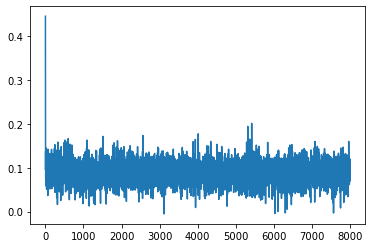

In [525]:
plt.plot(xs)
Audio(xs, rate=8000)

## export to ONNX

In [526]:
opset = 14#backend.Caffe2Backend._known_opset_version
opset

14

In [537]:
h = rnn.h0.detach()
x = torch.zeros(1,1)
x_block = torch.zeros(1,16,1)
u = torch.rand(1, 1)
        
# torch.onnx.export(
#     basic,
#     (h,x),                    # model input (or a tuple for multiple inputs)
#     'basic.onnx',                         # where to save the model (can be a file or file-like object)
#     export_params=True,        # store the trained parameter weights inside the model file
#     opset_version=opset,          # the ONNX version to export the model to
#     do_constant_folding=True,  # whether to execute constant folding for optimization
#     input_names = ['prev_state', 'input'],   # the model's input names
#     output_names = ['output'], # the model's output names
#     # verbose=True
# )

onnx_file = 'test.onnx'
torch.onnx.export(
    ExportWrapper(rnn, 'sample', temp=temp), # nn.Module
    (h, x),                                  # model input
    onnx_file,                               # file to save the model
    opset_version=opset,                     # ONNX version
    do_constant_folding=True,
    input_names = ['prev_state', 'input'],  
    output_names = ['next_state', 'output'],
    # verbose=True
)

onnx_file_norng = 'test_norng.onnx'
torch.onnx.export(
    ExportWrapper(rnn, 'sample', temp=temp), 
    (h, x, u),                               
    onnx_file_norng,                         
    opset_version=opset,                     
    do_constant_folding=True,                
    input_names = ['prev_state', 'input', 'rng'], 
    output_names = ['next_state', 'output'],
    # verbose=True
)

onnx_file_block = 'test_block.onnx'
torch.onnx.export(
    ExportWrapper(rnn, 'sample_n', n=n, temp=temp),
    (h, x_block),                  
    onnx_file_block,               
    opset_version=opset,          
    do_constant_folding=True,  
    input_names = ['prev_state', 'input'], 
    output_names = ['next_state', 'output'],
    # verbose=True
)

## load with python onnx package

In [538]:
import onnx
# help(onnx)

In [541]:
# Load the ONNX model
onnx_model = onnx.load(onnx_file)
onnx_model_norng = onnx.load(onnx_file_norng)
onnx_model_block = onnx.load(onnx_file_block)

# Check that the IR is well formed
onnx.checker.check_model(onnx_model)
onnx.checker.check_model(onnx_model_norng)
onnx.checker.check_model(onnx_model_block)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch-jit-export (
  %prev_state[FLOAT, 1x128]
  %input[FLOAT, 1x1]
) initializers (
  %model.rnn.weight_ih_l0[FLOAT, 384x64]
  %model.rnn.weight_hh_l0[FLOAT, 384x128]
  %model.rnn_cell.bias_ih[FLOAT, 384]
  %model.rnn_cell.bias_hh[FLOAT, 384]
  %model.proj.weight[FLOAT, 2x128]
  %model.proj.bias[FLOAT, 2]
  %model.emb.weight[FLOAT, 64x1]
  %model.emb.bias[FLOAT, 64]
  %65[INT64, 2]
) {
  %13 = Gemm[alpha = 1, beta = 1, transB = 1](%input, %model.emb.weight, %model.emb.bias)
  %14 = Gemm[alpha = 1, beta = 1, transB = 1](%13, %model.rnn.weight_ih_l0, %model.rnn_cell.bias_ih)
  %15 = Constant[value = <Tensor>]()
  %16, %17, %18 = Split[axis = 1](%14, %15)
  %19 = Gemm[alpha = 1, beta = 1, transB = 1](%prev_state, %model.rnn.weight_hh_l0, %model.rnn_cell.bias_hh)
  %20 = Constant[value = <Tensor>]()
  %21, %22, %23 = Split[axis = 1](%19, %20)
  %24 = Add(%21, %16)
  %25 = Sigmoid(%24)
  %26 = Add(%22, %17)
  %27 = Sigmoid(%26)
  %28 = Mul(%23, %25)
  %29 = Add(%18, %28)
  %30 = Tanh

In [427]:
# onnx_model.graph

## run with caffe2

In [542]:
h = np.zeros((1, rnn.hidden_size), np.float32)
x = np.array([[0.]]).astype(np.float32)
u = np.random.rand(1,1).astype(np.float32)

In [543]:
import caffe2.python.onnx.backend as backend

rep = backend.prepare(onnx_model_norng, device="CPU") # or "CUDA:0"
# For the Caffe2 backend:
#     rep.predict_net is the Caffe2 protobuf for the network
#     rep.workspace is the Caffe2 workspace for the network
#       (see the class caffe2.python.onnx.backend.Workspace)
outputs = rep.run((h, x, u))
print(outputs[0])

/Users/victor/anaconda3/envs/rnn-export/lib/python3.9/site-packages/caffe2/python/onnx/backend.py:687: UserWarning: This version of onnx-caffe2 targets ONNX operator set version 9, but the model we are trying to import uses version 14.  We will try to import it anyway, but if the model uses operators which had BC-breaking changes in the intervening versions, import will fail.
  warnings.warn("This version of onnx-caffe2 targets ONNX operator set version {}, but the model we are trying to import uses version {}.  We will try to import it anyway, but if the model uses operators which had BC-breaking changes in the intervening versions, import will fail.".format(cls._known_opset_version, imp.version))
/Users/victor/anaconda3/envs/rnn-export/lib/python3.9/site-packages/caffe2/python/onnx/backend.py:878: UserWarning: ShapeInferenceWarning: utils module not found in ONNX version 1.10.1
  warnings.warn("ShapeInferenceWarning: utils module not found in ONNX version {}".format(onnx.__version__)

RuntimeError: [enforce fail at net.cc:70] . op MatMul: Source for input model.emb.weight is unknown for net torch-jit-export_init, operator input: "input" input: "model.emb.weight" output: "OC2_DUMMY_0" name: "" type: "MatMul" arg { name: "trans_a" i: 0 } arg { name: "trans_b" i: 1 }

caffe2 doesn't do RNG. https://github.com/onnx/onnx-caffe2/blob/master/tests/ONNXOpCoverage.md

even passing in the random source, it will not work...

with torch 1.9.1, doesn't support the current onnx

downgrading onnx did not work either -- onnx.optimizer is there but fails somehow

now with pytorch-nightly and latest onnx, it has this "source for input is unknown" error

## run with onnxruntime

In [544]:
import onnxruntime as ort
ort_session = ort.InferenceSession('test.onnx')
ort_session_norng = ort.InferenceSession('test_norng.onnx')
ort_session_block = ort.InferenceSession('test_block.onnx')

In [550]:
%%timeit
h = np.zeros((1, rnn.hidden_size), np.float32)
x = np.array([[0.]]).astype(np.float32)
xs = []
for _ in range(8000):
    h, x = ort_session.run(None, {'prev_state': h, 'input':x})
    xs.append(x.item())

564 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [551]:
%%timeit
h = np.zeros((1, rnn.hidden_size), np.float32)
x = np.array([[0.]]).astype(np.float32)
xs = []
for _ in range(8000):
    u = np.random.rand(1,1).astype(np.float32)
    h, x = ort_session_norng.run(None, {'prev_state': h, 'input':x, 'rng':u})
    xs.append(x.item())

584 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [552]:
%%timeit
h = np.zeros((1, rnn.hidden_size), np.float32)
x_block = np.zeros((1,n,1), np.float32)
xs = []
for _ in range(8000//n):
    h, x_block = ort_session_block.run(None, {'prev_state': h, 'input':x_block})
    xs.extend(x_block[0,:,0])

503 ms ± 28.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


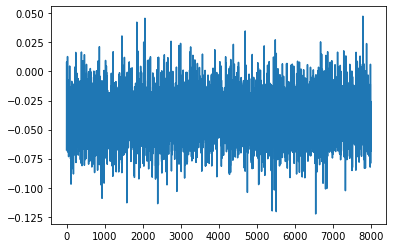

In [549]:
plt.plot(xs)
Audio(xs, rate=8000)

onnxruntime is about 2x faster on my mac, which is nice to see

not much benefit from blocks of size 16 though

## run with TVM

In [553]:
# onnx_basic = onnx.load('basic.onnx')

In [554]:
import sys
sys.path.append('/Users/victor/tvm/python')
import tvm
from tvm import te
import tvm.relay as relay

In [555]:
# h = np.zeros((1, basic.hidden_size), np.float32)
# x = np.array([[0.]]).astype(np.float32)

# tvm_target = 'llvm'

# shape_dict = {'prev_state': h.shape, 'input': x.shape}
# mod, params = relay.frontend.from_onnx(onnx_basic, shape_dict)

# with tvm.transform.PassContext(opt_level=1):
#     executor = relay.build_module.create_executor(
#         'graph', mod, tvm.cpu(0), tvm_target, params
#     ).evaluate()

In [556]:
# tvm_h, tvm_x = [torch.from_numpy(item.numpy()) for item in executor(tvm.nd.array(h), tvm.nd.array(x))]
# torch_h, torch_x = basic(torch.from_numpy(h), torch.from_numpy(x))
# torch_x-tvm_x, (torch_h-tvm_h).abs().max()

In [559]:
h = np.ones((1, rnn.hidden_size), np.float32)
x = np.zeros((1,1), np.float32)

shape_dict = {'prev_state': h.shape, 'input':x.shape}
mod, params = relay.frontend.from_onnx(onnx_model, shape_dict)

with tvm.transform.PassContext(opt_level=1):
    executor = relay.build_module.create_executor(
        'graph', mod, tvm.cpu(0), tvm_target, params
    ).evaluate()

OpNotImplemented: The following operators are not supported for frontend ONNX: RandomUniformLike

TVM also does not do RNG?

In [561]:
h = np.ones((1, rnn.hidden_size), np.float32)
x = np.zeros((1,1), np.float32)
u = 0.5*np.ones((1,1), np.float32)

shape_dict = {'prev_state': h.shape, 'input':x.shape, 'rng':u.shape}
mod, params = relay.frontend.from_onnx(onnx_model_norng, shape_dict)

with tvm.transform.PassContext(opt_level=1):
    executor = relay.build_module.create_executor(
        'graph', mod, tvm.cpu(0), tvm_target, params
    ).evaluate()

In [562]:
tvm_h, tvm_x = [torch.from_numpy(item.numpy()) for item in executor(tvm.nd.array(h), tvm.nd.array(x), tvm.nd.array(u))]
tvm_x

tensor([[0.0296]])

In [563]:
%%timeit
h = tvm.nd.array(np.zeros((1, rnn.hidden_size), np.float32))
x = tvm.nd.array(np.array([[0.]]).astype(np.float32))
u = tvm.nd.array(np.zeros((1,1), np.float32))
xs = []
for _ in range(8000):
    # u = tvm.nd.array(np.random.rand(1,1).astype(np.float32))    
    h, x = executor(h, x, u)
    # xs.append(x.numpy().item())

2.21 s ± 58.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


using TVM this way is 2x *slower*